In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from __future__ import division
from IPython.display import display, HTML

In [3]:
import seaborn as sns
import pandas as pd
import MySQLdb as mdb
import bs4
import datetime
import time
from collections import defaultdict

### Some Helper Functions

In [4]:
import webbrowser

def issue_id_to_local_id(issue_id):
    return chrome_issue[chrome_issue["issue_id"] == issue_id]["local_id"].values[0]

def open_issue_webpage(issue_id):
    '''This Function opens the webpage of the issue corresponding to issue_id.S'''
    chromium_path = "https://bugs.chromium.org/p/chromium/issues/detail?id="
    local_id = issue_id_to_local_id(issue_id)
    webbrowser.open_new(chromium_path + str(local_id))

In [5]:
def table_to_dataframe(name, connection):
    return pd.read_sql("SELECT * FROM {};".format(name) , con=connection)

In [6]:
def histrogram_plot(count_data, title, x_label, y_label, kde=False, hist=True):
    sns.distplot(count_data, kde=kde, hist=hist)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [7]:
connection = mdb.connect(host="173.194.230.234", user="noblek", db="monorail")

In [8]:
cursor = connection.cursor()

### The Names of the tables in the Database

In [9]:
cursor.execute("SHOW  TABLES")
for (table_name,) in cursor:
    print(table_name)

Attachment
AutocompleteExclusion
Comment
Component2Admin
Component2Cc
Component2Label
ComponentDef
DanglingIssueRelation
DismissedCues
ExtraPerm
FieldDef
FieldDef2Admin
FilterRule
Group2Project
Invalidate
Issue
Issue2Cc
Issue2Component
Issue2FieldValue
Issue2Label
Issue2Notify
IssueFormerLocations
IssueRelation
IssueStar
IssueSummary
IssueUpdate
LabelDef
LocalIDCounter
MemberNotes
Project
Project2SavedQuery
ProjectIssueConfig
ProjectStar
QuickEditHistory
QuickEditMostRecent
ReindexQueue
SavedQuery
SavedQueryExecutesInProject
SpamReport
SpamVerdict
StatusDef
Template
Template2Admin
Template2Component
Template2FieldValue
Template2Label
User
User2Project
User2SavedQuery
UserGroup
UserGroupSettings
UserStar
_Comment_old
dsns


### Load the tables that will be used for analysis

In [10]:
issue = table_to_dataframe("Issue", connection)
comment = table_to_dataframe("Comment", connection)
issue_summarny = table_to_dataframe("IssueSummary", connection)
issue_label = table_to_dataframe("Issue2Label", connection)
issue_component = table_to_dataframe("Issue2Component", connection)

In [11]:
issue.rename(columns={"id":"issue_id"}, inplace=True)

### Select for only Chromium Projects

In [12]:
chrome_issue = issue[issue["project_id"] == 16].copy()

In [13]:
chrome_comment = comment[comment["project_id"] == 16]

In [14]:
print("Number of Chromium Issues", chrome_issue.shape[0])
print("Number of Chromium Comments", chrome_comment.shape[0])

Number of Chromium Issues 611859
Number of Chromium Comments 5712584


In [15]:
unique_chrome_issues = set(chrome_issue["issue_id"])

### Associate comments with their Issues

In [16]:
comments_by_issue = defaultdict(list)
i = 0
for index, row in chrome_comment.iterrows():
    comments_by_issue[row["issue_id"]].append((index, row.created))
    if i % 1000000 == 0:
        print(i)
    i += 1

0
1000000
2000000
3000000
4000000
5000000


### Make sure the list of Comments for each issue are sorted by time

In [17]:
chrome_issue["comments"] = chrome_issue["issue_id"].apply(lambda i_id: [tup[0] for tup in sorted(comments_by_issue[i_id], key=lambda x: x[1])])

### Explore the number of comments per issue

In [18]:
chrome_issue["num_comments"] = chrome_issue["comments"].apply(lambda comments: len(comments))

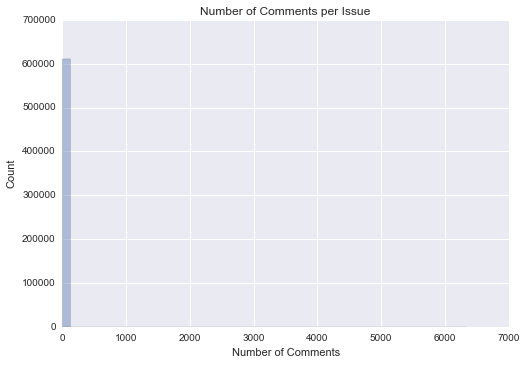

In [19]:
histrogram_plot(chrome_issue["num_comments"], "Number of Comments per Issue","Number of Comments", "Count")

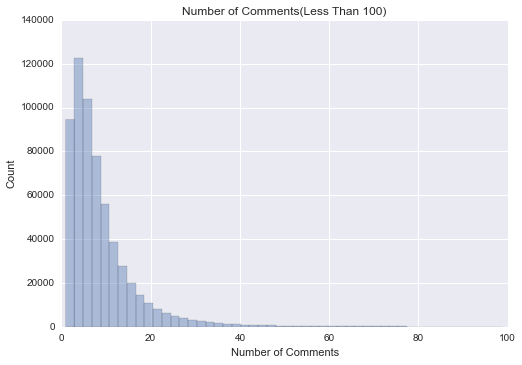

In [20]:
histrogram_plot(chrome_issue[chrome_issue["num_comments"] < 100]["num_comments"], "Number of Comments(Less Than 100)", "Number of Comments", "Count")

Statistics of the number of comments per issue

In [21]:
chrome_issue["num_comments"].describe()

count    611859.000000
mean          9.336439
std          27.077464
min           1.000000
25%           4.000000
50%           6.000000
75%          11.000000
max        6354.000000
Name: num_comments, dtype: float64

In [22]:
print("The Number of Deleted Comments:", np.where(~np.isnan(chrome_comment["deleted_by"]))[0].shape[0])

The Number of Deleted Comments: 49186


### Coarse Plots of Comments over time

It appears that it is not unusal for issues to be commented on the order of years

In [23]:
def plot_comments_over_time(comments):
    num_comments = len(comments)
    plt.plot(map(datetime.datetime.fromtimestamp, comments["created"]), xrange(1, num_comments+1))
    plt.xlabel("Time")
    plt.ylabel("Number of Comments")
    plt.title("time vs number of comments")

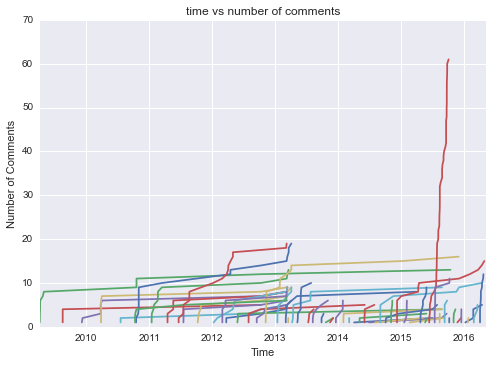

In [24]:
for idx in xrange(0, len(chrome_issue), 10000):
    if len(chrome_issue.iloc[idx]["comments"]) > 500:
        continue
    plot_comments_over_time(chrome_comment.loc[chrome_issue.iloc[idx]["comments"]])

### Explore The timeframe from when an issue is opened to closed

In [25]:
time_to_closure = (chrome_issue["closed"] - chrome_issue["opened"])
time_to_closure = time_to_closure[time_to_closure > 0]

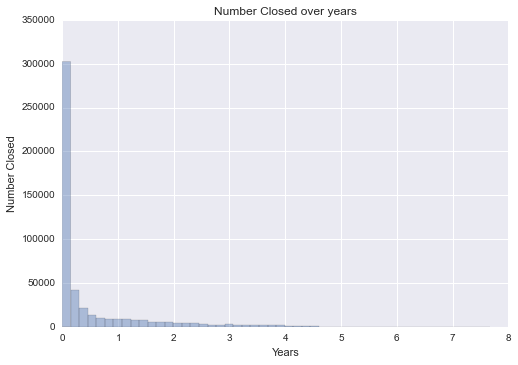

In [26]:
histrogram_plot(time_to_closure / (365*24*3600), "Number Closed over years", "Years", "Number Closed")

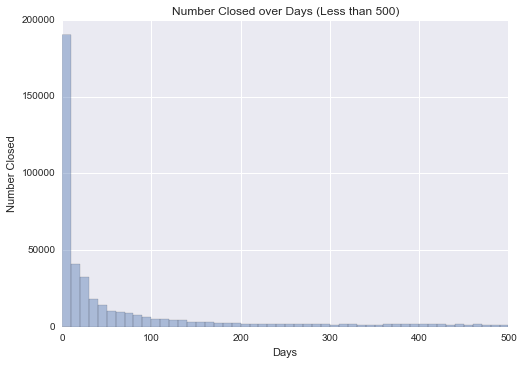

In [27]:
histrogram_plot(time_to_closure[time_to_closure < (500*24*3600)] / (3600 * 24), "Number Closed over Days (Less than 500)", "Days", "Number Closed")

Statistics on time to closure

In [28]:
print("Average time to closure", time_to_closure.mean() / (3600 * 24), "Days")
print("Median time to closure", time_to_closure.median() / (3600 * 24), "Days")
print("Standard Deviation of time to closure", time_to_closure.std() / (3600 * 24), "Days")

Average time to closure 177.271462655 Days
Median time to closure 21.178587963 Days
Standard Deviation of time to closure 335.366124974 Days


### Explore the length of a typical comment (Really Rough still need to remove markup, stop words, etc...) I'm also not differentiting between first comment and everything else.
...

In [29]:
length_of_comments = chrome_comment["content"].apply(lambda content: len(content.split()))

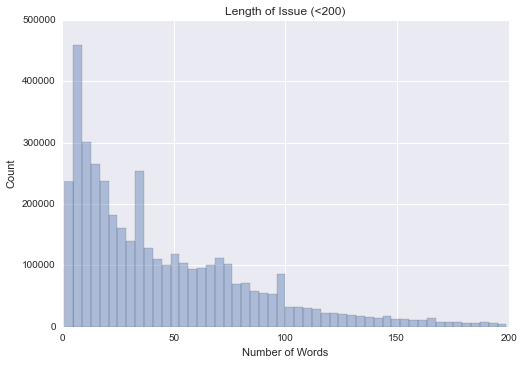

In [30]:
histrogram_plot(length_of_comments[(length_of_comments > 0) & (length_of_comments < 200)], "Length of Issue (<200)", "Number of Words", "Count")

Statistics on the lengh of Comments

In [31]:
length_of_comments.describe()

count    5.712584e+06
mean     3.971911e+01
std      7.033108e+01
min      0.000000e+00
25%      0.000000e+00
50%      1.800000e+01
75%      5.600000e+01
max      7.504000e+03
Name: content, dtype: float64

## Explore Labels

In [32]:
chrome_issue_id_set = set(chrome_issue["issue_id"])

In [33]:
labels_by_issue = defaultdict(list)
num_times_label_used = defaultdict(int)
i = 0
for index, row in issue_label.iterrows():
    if row["issue_id"] in chrome_issue_id_set:
        labels_by_issue[row["issue_id"]].append(row["label_id"])
        num_times_label_used[row["label_id"]] += 1
    if i % 1000000 == 0:
        print(i)
    i += 1

0
1000000
2000000
3000000


In [34]:
chrome_issue["labels"] = chrome_issue["issue_id"].apply(lambda i_id: labels_by_issue[i_id])

In [35]:
chrome_issue["num_labels"] = chrome_issue["labels"].apply(lambda labels_list: len(labels_list))

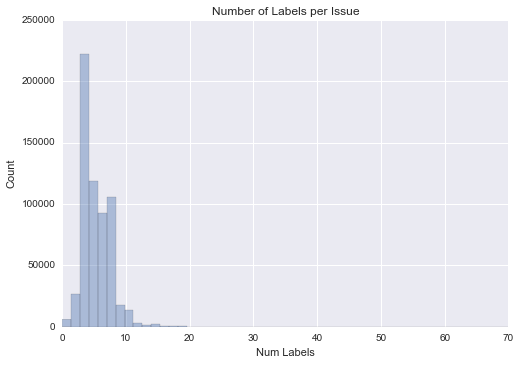

In [36]:
histrogram_plot(chrome_issue["num_labels"], "Number of Labels per Issue", "Num Labels", "Count")

Statistics on Labels per Issue

In [37]:
chrome_issue["num_labels"].describe()

count    611859.000000
mean          5.243520
std           2.379956
min           0.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          70.000000
Name: num_labels, dtype: float64

In [38]:
number_times_label_used = pd.DataFrame(num_times_label_used.items(), columns=["label_id", "number_time_used"])

In [39]:
print("Number of Unique Labels", number_times_label_used.shape[0])

Number of Unique Labels 20493


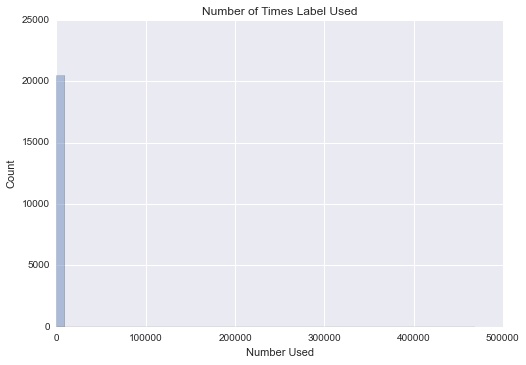

In [40]:
histrogram_plot(number_times_label_used["number_time_used"], "Number of Times Label Used", "Number Used", "Count")

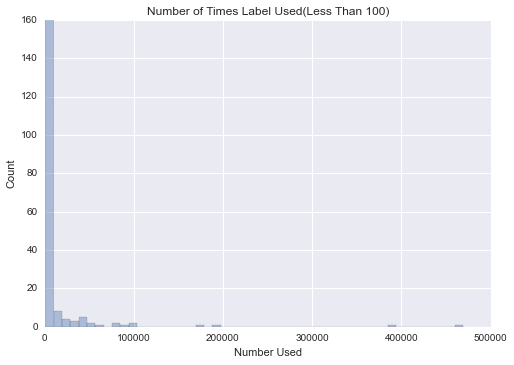

In [41]:
histrogram_plot(number_times_label_used[number_times_label_used["number_time_used"] > 1000]["number_time_used"], "Number of Times Label Used(Less Than 100)", "Number Used", "Count")

Statistics on how often labels have been used

In [42]:
number_times_label_used["number_time_used"].describe()

count     20493.000000
mean        156.555653
std        4947.912097
min           1.000000
25%           1.000000
50%           1.000000
75%           5.000000
max      469002.000000
Name: number_time_used, dtype: float64

In [43]:
number_times_label_used[number_times_label_used["number_time_used"] > 450000]

,label_id,number_time_used
17030,18246154,469002


In [44]:
label_def = table_to_dataframe("LabelDef", connection)

In [45]:
label_def[label_def["id"] == 18246154]

,id,project_id,label,rank,docstring,deprecated
5566,18246154,16,Type-Bug,215.0,Software not working correctly,0.0


## Explore Components

In [46]:
components_by_issue = defaultdict(list)
num_times_comp_used = defaultdict(int)
i = 0
for index, row in issue_component.iterrows():
    if row["issue_id"] in chrome_issue_id_set:
        components_by_issue[row["issue_id"]].append(row["component_id"])
        num_times_comp_used[row["component_id"]] += 1
    if i % 100000 == 0:
        print(i)
    i += 1

0
100000
200000
300000
400000
500000


In [47]:
chrome_issue["components"] = chrome_issue["issue_id"].apply(lambda i_id: components_by_issue[i_id])
chrome_issue["num_components"] = chrome_issue["components"].apply(lambda comp_list: len(comp_list))

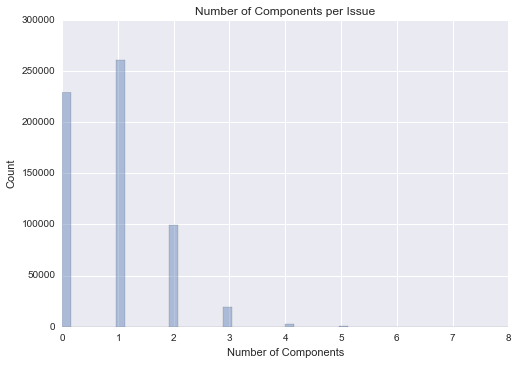

In [48]:
histrogram_plot(chrome_issue["num_components"], "Number of Components per Issue", "Number of Components", "Count")

Statistics on Components per issue

In [49]:
chrome_issue["num_components"].describe()

count    611859.000000
mean          0.870696
std           0.843908
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: num_components, dtype: float64

In [50]:
number_comp_used = pd.DataFrame(num_times_comp_used.items(), columns=["component_id", "number_time_used"])

In [51]:
print("Number of Unique Components", number_comp_used.shape[0])

Number of Unique Components 657


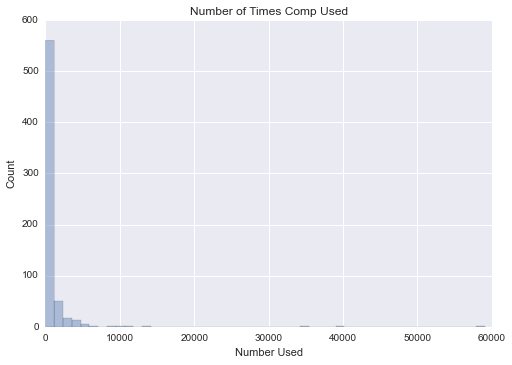

In [52]:
histrogram_plot(number_comp_used["number_time_used"], "Number of Times Comp Used", "Number Used", "Count")

### Statistics on Component Frequency

In [53]:
number_comp_used["number_time_used"].describe()

count      657.000000
mean       810.872146
std       3318.952857
min          1.000000
25%         15.000000
50%        121.000000
75%        557.000000
max      59116.000000
Name: number_time_used, dtype: float64

### Use Issue Updates to determine time to correct component assignment

In [54]:
component_def = table_to_dataframe("ComponentDef", connection)

In [55]:
chrome_components = component_def[component_def["project_id"] == 16]

In [56]:
issue_update = table_to_dataframe("IssueUpdate", connection)

In [57]:
chrome_issue_update = issue_update[issue_update["issue_id"].isin(unique_chrome_issues)]
chrome_comp_updates = chrome_issue_update[chrome_issue_update["field"] == "components"]

In [58]:
updates_by_issue_id = dict()
i = 0
for index, row in chrome_issue.iterrows():
    issue_id = row["issue_id"]
    updates_by_issue_id[issue_id] = []
    for comp_index, comp_row in chrome_comp_updates[chrome_comp_updates["issue_id"] == issue_id].iterrows():
        updates_by_issue_id[issue_id].append(comp_index)
    
    if i % 100000 == 0:
        print(i)
    i += 1

0
100000
200000
300000
400000
500000
600000


In [59]:
chrome_issue["comp_updates"] = chrome_issue["issue_id"].apply(lambda i_id: updates_by_issue_id[i_id])
chrome_issue["num_comp_updates"] = chrome_issue["issue_id"].apply(lambda i_id: len(updates_by_issue_id[i_id]))

### Work only with Closed Issues to determine time to correct component assignment

In [60]:
closed_chrome_issue = chrome_issue[chrome_issue["closed"] != 0]

In [61]:
print("The Number of closed chrome issues", closed_chrome_issue.shape[0])

The Number of closed chrome issues 538161


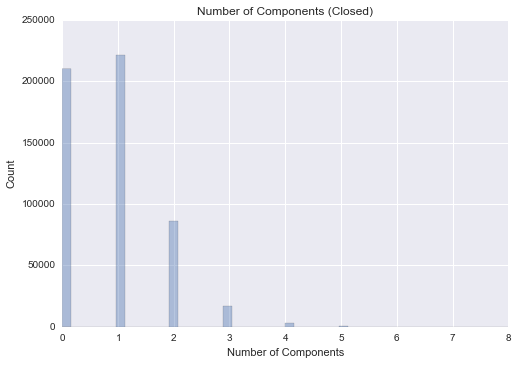

In [62]:
histrogram_plot(closed_chrome_issue["num_components"], "Number of Components (Closed)", "Number of Components", "Count")

### Statistics on Component assignment for closed chrome issues

In [63]:
closed_chrome_issue["num_components"].describe()

count    538161.000000
mean          0.853496
std           0.850581
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: num_components, dtype: float64

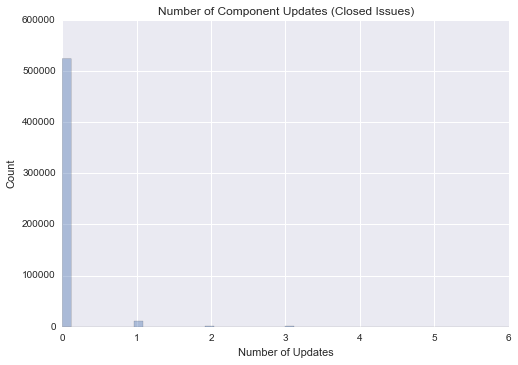

In [64]:
histrogram_plot(closed_chrome_issue["num_comp_updates"], "Number of Component Updates (Closed Issues)", "Number of Updates", "Count")

### Only include issues that were created after issue tracking was transorted to Monorail

In [65]:
import_date = "02/18/2016"
import_date = time.mktime(datetime.datetime.strptime(import_date, "%m/%d/%Y").timetuple())

In [66]:
closed_chrome_issues_monorail = closed_chrome_issue[closed_chrome_issue["opened"] > import_date]

In [67]:
closed_chrome_issues_monorail.shape

(12381, 24)

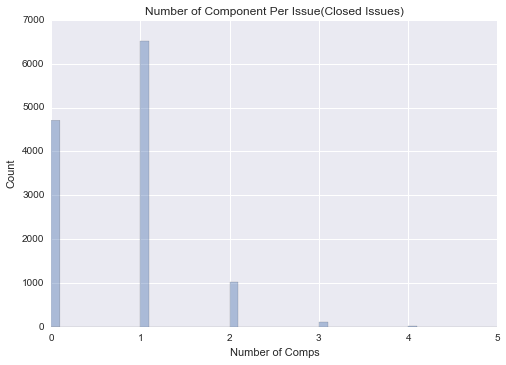

In [68]:
histrogram_plot(closed_chrome_issues_monorail["num_components"],  "Number of Component Per Issue(Closed Issues)", "Number of Comps", "Count")

In [69]:
closed_chrome_issues_monorail["num_components"].describe()

count    12381.000000
mean         0.725305
std          0.663298
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: num_components, dtype: float64

In [70]:
closed_chrome_with_comps = closed_chrome_issues_monorail[closed_chrome_issues_monorail["num_components"] > 0]

In [71]:
print("Number of Closed Issues with Components (opened after 2/18/2016)", closed_chrome_with_comps.shape[0])

Number of Closed Issues with Components (opened after 2/18/2016) 7672


In [72]:
print("Number of Closed Issues with no Components (opened after 2/18/2016)", np.sum(closed_chrome_issues_monorail["num_components"] == 0))

Number of Closed Issues with no Components (opened after 2/18/2016) 4709


In [73]:
no_comps_with_updates = closed_chrome_issues_monorail[(closed_chrome_issues_monorail["num_comp_updates"] > 0) & (closed_chrome_issues_monorail["num_components"] == 0)]

In [74]:
print("Number of Issues that were asigned a componet but were closed with no componet:", no_comps_with_updates.shape[0])

Number of Issues that were asigned a componet but were closed with no componet: 27


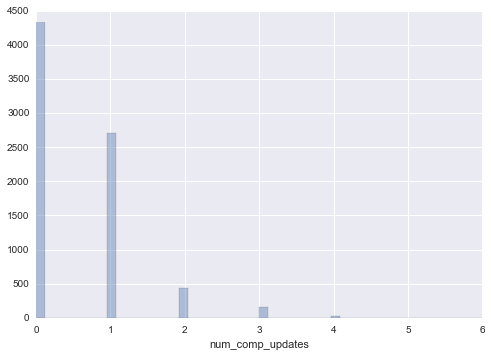

In [75]:
sns.distplot(closed_chrome_with_comps["num_comp_updates"], kde=False)

In [76]:
def time_of_last_component_1(updates):
    # If there are no comp updates then all comp assignments 
    # were assigned during issue creation
    if len(updates) == 0:
        return 0
    # If there is more than one update the time to correct component assignment
    # is the time of the last assignment. Note that this interpretation assumes
    # a correct component assignment as being not just assinging the correct one
    # but also removing any incorrect ones.
    comment_id = updates.iloc[-1]["comment_id"]
    return chrome_comment[chrome_comment["id"] == comment_id]["created"].values[0]
        

In [77]:
i = 0
time_to_comp_assignment = dict()
for index, row in closed_chrome_with_comps.iterrows():
    ish_id = row["issue_id"]
    updates = chrome_comp_updates.loc[row["comp_updates"]]
    time = time_of_last_component_1(updates)
    if time == 0:
        time_to_comp_assignment[ish_id] = time
    else:
        time = time - row["opened"]
        time_to_comp_assignment[ish_id] = time
    
    if (i % 1000) == 0:
        print(i)
    i += 1
    

0
1000
2000
3000
4000
5000
6000
7000


### Histogram Showing time to correct component assignment

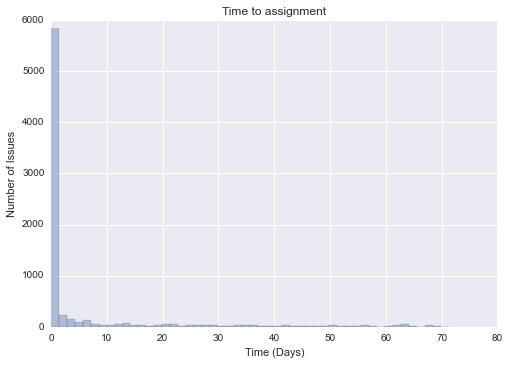

In [78]:
histrogram_plot(pd.DataFrame(time_to_comp_assignment.items())[1] / (3600*24), "Time to assignment", "Time (Days)", "Number of Issues")

In [79]:
(pd.DataFrame(time_to_comp_assignment.items())[1] / (3600*24)).describe()

count    7672.000000
mean        5.716000
std        14.322087
min         0.000000
25%         0.000000
50%         0.000000
75%         1.160851
max        71.252500
Name: 1, dtype: float64

In [80]:
no_comp = closed_chrome_issues_monorail[closed_chrome_issues_monorail["num_components"] == 0]
with_comp = closed_chrome_issues_monorail[closed_chrome_issues_monorail["num_components"] != 0]

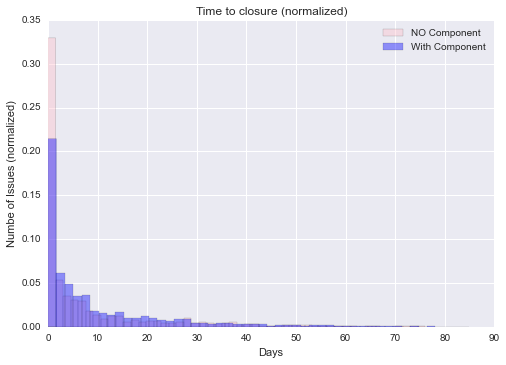

In [81]:
sns.distplot((no_comp["closed"] - no_comp["opened"]) / (3600 * 24), kde=False, label="NO Component", norm_hist=True, color="pink")
sns.distplot((with_comp["closed"] - with_comp["opened"]) / (3600 * 24), kde=False, label="With Component", norm_hist=True, color="Blue")
plt.xlabel("Days")
plt.ylabel("Numbe of Issues (normalized)")
plt.title("Time to closure (normalized)")
plt.legend()

In [82]:
((no_comp["closed"] - no_comp["opened"]) / (3600 * 24)).describe()

count    4709.000000
mean        7.838234
std        13.047354
min         0.000000
25%         0.254734
50%         1.507581
75%         8.759780
max        76.061817
dtype: float64

In [83]:
((with_comp["closed"] - with_comp["opened"]) / (3600 * 24)).describe()

count    7672.000000
mean        9.754343
std        13.647165
min         0.000000
25%         0.735463
50%         4.048987
75%        13.455067
max        84.907685
dtype: float64

### Perform the same analysis as above but now excluding issues marked as "WontFix" or "Duplicate"

In [84]:
status_def = table_to_dataframe("StatusDef", connection)

In [85]:
chrome_not_valid = set(chrome_issue_update[(chrome_issue_update["new_value"] == "WontFix") | 
                                  (chrome_issue_update["new_value"] == "Duplicate")]["issue_id"])

In [86]:
closed_chrome_valid = closed_chrome_issue[closed_chrome_issue["issue_id"].apply(lambda i_id: i_id not in chrome_not_valid)]

In [87]:
no_comp_valid = closed_chrome_valid[closed_chrome_valid["num_components"] == 0]
with_comp_valid = closed_chrome_valid[closed_chrome_valid["num_components"] != 0]

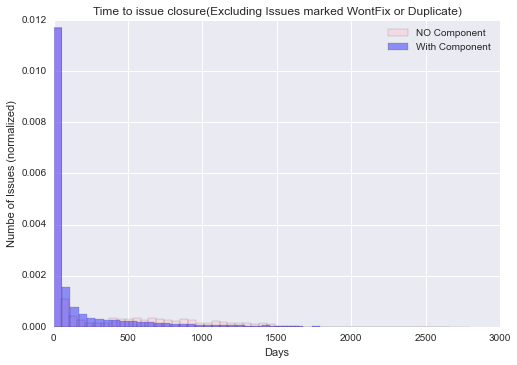

In [88]:
sns.distplot((no_comp_valid["closed"] - no_comp_valid["opened"]) / (3600 * 24), kde=False, label="NO Component", norm_hist=True, color="pink")
sns.distplot((with_comp_valid["closed"] - with_comp_valid["opened"]) / (3600 * 24), kde=False, label="With Component", norm_hist=True, color="Blue")
plt.xlabel("Days")
plt.ylabel("Numbe of Issues (normalized)")
plt.title("Time to issue closure(Excluding Issues marked WontFix or Duplicate)")
plt.legend()

In [89]:
((no_comp_valid["closed"] - no_comp_valid["opened"]) / (3600 * 24)).describe()

count    94498.000000
mean       246.740942
std        408.972934
min          0.000000
25%          0.000000
50%         11.163003
75%        411.270145
max       2656.412662
dtype: float64

In [90]:
((with_comp_valid["closed"] - with_comp_valid["opened"]) / (3600 * 24)).describe()

count    177877.000000
mean        153.512277
std         311.320375
min           0.000000
25%           3.199873
50%          19.683600
75%         120.228102
max        2798.843438
dtype: float64